In [1]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib notebook
import seaborn as sns
import os
import sys
sys.path.append("..")
sys.path.append("../src")

import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import utils
import shell

In [2]:
# dataset_directory = "data/people"
dataset_directory = "../data/STL10/images"
# dataset_directory = "data/fruits"

In [3]:
# shell_family = shell.ShellFamily("resnet50")
shell_family = shell.ShellFamily()
shell_family.create_preprocessor("resnet50")
# shell_family.load("test.pkl")

In [4]:
def get_class_folders_from_main_directory(directory):
    sub_folders = next(os.walk(directory))[1]
    classes = sub_folders.copy()
    for i in range(len(sub_folders)):
        sub_folders[i] = os.path.join(directory, sub_folders[i])
    return sorted(sub_folders), classes

def extract_classes_sub_folder(sub_folders):
    all_image_filepaths = np.array([])
    class_array = np.array([])
    for i in range(len(sub_folders)):
        image_files = os.listdir(sub_folders[i])
        image_filepaths = list(map(lambda x : os.path.join(sub_folders[i], x), image_files))
        new_image_filepaths = []
        for j in image_filepaths:
            try:
                Image.open(j)
                new_image_filepaths.append(j)
            except:
                continue
        all_image_filepaths = np.append(all_image_filepaths, new_image_filepaths)
        class_array = np.append(class_array, [i] * len(new_image_filepaths))
#         all_image_filepaths = np.append(all_image_filepaths, image_filepaths)
#         class_array = np.append(class_array, [i] * len(image_filepaths))
    return all_image_filepaths, class_array.astype(np.int32)

In [5]:
class ImageGenerator():
    def __init__(self, filepath_array, class_array, batch_size, target_size):
        self.filepath_array = filepath_array
        self.class_array = class_array
        self.batch_size = batch_size
        self.target_size = target_size
        self.steps = len(self.class_array) // self.batch_size
        self.index = 0
        print("Found {} images with {} classes!".format(self.__len__(), len(np.unique(self.class_array))))
    
    def __iter__(self):
        return self
    
    def __len__(self):
        assert(len(self.class_array) == len(self.filepath_array))
        return len(self.class_array)
    
    def __next__(self):
        if self.index == self.__len__():
            raise StopIteration
        elif self.index + self.batch_size >= self.__len__():
            batch_filepaths = self.filepath_array[self.index : self.__len__()]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.__len__()]
            self.index = self.__len__()
            return (batch_images, batch_filepaths, batch_classes)
        else:
            batch_filepaths = self.filepath_array[self.index : self.index + self.batch_size]
            batch_images = np.array([np.asarray(Image.open(i).convert("RGB").resize(self.target_size))[..., :3] for i in batch_filepaths]).astype(np.float32)
            batch_images = preprocess_input(batch_images)
            batch_classes = self.class_array[self.index : self.index + self.batch_size]
            self.index += self.batch_size
            return (batch_images, batch_filepaths, batch_classes)

In [6]:
sub_folders, classes = get_class_folders_from_main_directory(dataset_directory)
filepath_array, class_array = extract_classes_sub_folder(sub_folders)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(filepath_array,
                                                    class_array,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=class_array)

In [8]:
train_image_generator = ImageGenerator(X_train, y_train, 2048, (224, 224))
test_image_generator = ImageGenerator(X_test, y_test, 1, (224, 224))

Found 4000 images with 10 classes!
Found 1000 images with 10 classes!


In [9]:
shell_family.fit(train_image_generator, classes, "../models/test.pkl")

In [24]:
y_predict = []
for processed_image_array, _, groundtruth in test_image_generator:
    sample_features = shell_family.preprocessor.predict(processed_image_array)
    class_index, class_name, score, full_results = shell_family.score(sample_features, 0.5, with_update=False, return_full_results=True)
    y_predict.append(class_index)
    print("predicted: {}, groundtruth: {}".format(class_name, shell_family.mapping[groundtruth[0]]))


predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Corn, groundtruth: Corn
predicted: Limes, groundtruth: Limes
predicted: Orange, groundtruth: Orange
predicted: Banana, groundtruth: Banana
predicted: Blueberry, groundtruth: Blueberry
predicted: Strawberry, groundtruth: Strawberry
predicted: Corn, groundtruth: Corn
predicted: Onion White, groundtruth: Onion White
predicted: Cherry, groundtruth: Cherry
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Raspberry, groundtruth: Raspberry
predicted: Lemon, groundtruth: Lemon
predicted: Cherry, groundtruth: Cherry
predicted: Clementine, groundtruth: Clementine
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Strawberry, groundtruth: Strawberry
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Mango, groundtruth: Mango
predicted: Raspberry, groundtruth: Raspberry
predicted: Pomegra

predicted: Pear, groundtruth: Pear
predicted: Strawberry, groundtruth: Strawberry
predicted: Plum, groundtruth: Plum
predicted: Kiwi, groundtruth: Kiwi
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Corn, groundtruth: Corn
predicted: Plum, groundtruth: Plum
predicted: Banana, groundtruth: Banana
predicted: Potato Red, groundtruth: Potato Red
predicted: Peach, groundtruth: Peach
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Pear, groundtruth: Pear
predicted: Pineapple, groundtruth: Pineapple
predicted: Clementine, groundtruth: Clementine
predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Corn, groundtruth: Corn
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Strawberry, groundtruth: Strawberry
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Potato Red, groundtruth: Potato Red
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Tomato, groundtruth: Tomato
predicted: Apricot,

predicted: Pepper Red, groundtruth: Pepper Red
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Watermelon, groundtruth: Watermelon
predicted: Clementine, groundtruth: Clementine
predicted: Onion White, groundtruth: Onion White
predicted: Potato Red, groundtruth: Potato Red
predicted: Papaya, groundtruth: Papaya
predicted: Peach, groundtruth: Peach
predicted: Tomato, groundtruth: Tomato
predicted: Strawberry, groundtruth: Strawberry
predicted: Potato Red, groundtruth: Potato Red
predicted: Watermelon, groundtruth: Watermelon
predicted: Watermelon, groundtruth: Watermelon
predicted: Strawberry, groundtruth: Strawberry
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Cherry, groundtruth: Cherry
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Plum, groundtruth: Plum
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Avocado, groundtruth: Avocado
predicted: Blueberry, groundtruth: Blueberry
predicted: Onion White, groundtruth: Onion Whit

predicted: Cactus fruit, groundtruth: Avocado
predicted: Lemon, groundtruth: Lemon
predicted: Plum, groundtruth: Plum
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Apricot, groundtruth: Apricot
predicted: Orange, groundtruth: Orange
predicted: Pear, groundtruth: Pear
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Banana, groundtruth: Banana
predicted: Clementine, groundtruth: Clementine
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Corn, groundtruth: Corn
predicted: Limes, groundtruth: Limes
predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Cherry, groundtruth: Cherry
predicted: Lemon, groundtruth: Lemon
predicted: Potato Red, groundtruth: Potato Red
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Corn, groundtruth: Corn
predicted: Cherry, groundtruth: Cherry
predicted: Tomato, groundtruth: Tomato
pred

predicted: Watermelon, groundtruth: Watermelon
predicted: Potato Red, groundtruth: Potato Red
predicted: Plum, groundtruth: Plum
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Papaya, groundtruth: Papaya
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Pear, groundtruth: Pear
predicted: Avocado, groundtruth: Avocado
predicted: Orange, groundtruth: Orange
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Orange, groundtruth: Orange
predicted: Cactus fruit, groundtruth: Papaya
predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Apricot, groundtruth: Apricot
predicted: Pear, groundtruth: Pear
predicted: Orange, groundtruth: Orange
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Plum, groundtruth: Plum
predicted: Orange, groundtruth: Orange
predicted: Potato Red, groundtruth: Potato

predicted: Tomato, groundtruth: Tomato
predicted: Plum, groundtruth: Plum
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Potato Red, groundtruth: Potato Red
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Blueberry, groundtruth: Blueberry
predicted: Cactus fruit, groundtruth: Watermelon
predicted: Mango, groundtruth: Mango
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Kiwi, groundtruth: Kiwi
predicted: Cactus fruit, groundtruth: Peach
predicted: Onion White, groundtruth: Onion White
predicted: Apricot, groundtruth: Apricot
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Blueberry, groundtruth: Blueberry
predicted: Mango, groundtruth: Mango
predicted: Papaya, groundtruth: Papaya
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Grape Blue, groundtruth: Grape Blue
predicted

predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Tomato, groundtruth: Tomato
predicted: Plum, groundtruth: Plum
predicted: Mango, groundtruth: Mango
predicted: Potato Red, groundtruth: Potato Red
predicted: Tomato, groundtruth: Tomato
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Mango, groundtruth: Mango
predicted: Cherry, groundtruth: Cherry
predicted: Apricot, groundtruth: Apricot
predicted: Clementine, groundtruth: Clementine
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Watermelon, groundtruth: Watermelon
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Orange, groundtruth: Orange
predicted: Avocado, groundtruth: Avocado
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
pred

predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Onion White, groundtruth: Onion White
predicted: Raspberry, groundtruth: Raspberry
predicted: Pear, groundtruth: Pear
predicted: Clementine, groundtruth: Clementine
predicted: Kiwi, groundtruth: Kiwi
predicted: Tomato, groundtruth: Tomato
predicted: Peach, groundtruth: Peach
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Potato Red, groundtruth: Potato Red
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Plum, groundtruth: Plum
predicted: Avocado, groundtruth: Avocado
predicted: Blueberry, groundtruth: Blueberry
predicted: Peach, groundtruth: Peach
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Plum, groundtruth: Plum
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Pear, groundtruth: Pear
predicted: Peach, groundtruth: Peach
p

predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Kiwi, groundtruth: Kiwi
predicted: Cherry, groundtruth: Cherry
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Papaya, groundtruth: Peach
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Tomato, groundtruth: Tomato
predicted: Limes, groundtruth: Limes
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Banana, groundtruth: Banana
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Pear, groundtruth: Pear
predicted: Orange, groundtruth: Orange
predicted: Mango, groundtruth: Mango
predicted: Corn, groundtruth: Corn
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Tomato, groundtruth: Tomato
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Tomato, groundtruth: Tomato
predicted: Apple Granny S

predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Cactus fruit, groundtruth: Avocado
predicted: Lemon, groundtruth: Lemon
predicted: Mango, groundtruth: Mango
predicted: Mango, groundtruth: Mango
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Mango, groundtruth: Mango
predicted: Plum, groundtruth: Plum
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Avocado, groundtruth: Avocado
predicted: Pear, groundtruth: Pear
predicted: Pineapple, groundtruth: Pineapple
predicted: Lemon, groundtruth: Lemon
predicted: Plum, groundtruth: Plum
predicted: Apple Braeburn, groundtruth: Pear
predicted: Papaya, groundtruth: Papaya
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Potato Red, groundtruth: Potato Red
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Limes, groundtruth: Limes
predicted: Watermelon, groundtruth: Water

predicted: Pomegranate, groundtruth: Pomegranate
predicted: Corn, groundtruth: Corn
predicted: Onion White, groundtruth: Onion White
predicted: Limes, groundtruth: Limes
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Strawberry, groundtruth: Strawberry
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Apricot, groundtruth: Apricot
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Tomato, groundtruth: Tomato
predicted: Blueberry, groundtruth: Blueberry
predicted: Cherry, groundtruth: Cherry
predicted: Apricot, groundtruth: Apricot
predicted: Watermelon, groundtruth: Watermelon
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Kiwi, groundtruth: Kiwi
predicted: Apricot, groundtruth: Apricot
predicted: Papaya, groundtruth: Papaya
predicted: Strawberry, groundtruth: Strawberry
predicted: Pear, groundtruth: Pear
predicted: Potato Red, groundtruth: Potato Red
predicted: Pepper Red, gro

predicted: Kiwi, groundtruth: Kiwi
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Pear, groundtruth: Pear
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Blueberry, groundtruth: Blueberry
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Papaya, groundtruth: Kiwi
predicted: Papaya, groundtruth: Papaya
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Pineapple, groundtruth: Pineapple
predicted: Peach, groundtruth: Peach
predicted: Raspberry, groundtruth: Raspberry
predicted: Tomato, groundtruth: Tomato
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Onion White, groundtruth: Onion White
predicted: Cherry, groundtruth: Cherry
predicted: Lemon, groundtruth: Lemon
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Banana, groundtruth: Banana
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Pineapple, gr

predicted: Cantaloupe, groundtruth: Cantaloupe
predicted: Blueberry, groundtruth: Blueberry
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Tomato, groundtruth: Tomato
predicted: Cactus fruit, groundtruth: Strawberry
predicted: Potato Red, groundtruth: Potato Red
predicted: Kiwi, groundtruth: Kiwi
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Peach, groundtruth: Peach
predicted: Peach, groundtruth: Peach
predicted: Watermelon, groundtruth: Watermelon
predicted: Apricot, groundtruth: Apricot
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Pear, groundtruth: Pear
predicted: Cherry, groundtruth: Cherry
predicted: Corn, groundtruth: Corn
predicted: Potato Red, groundtruth: Potato Red
predicted: Cherry, groundtruth: Cherry
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Cucumber Ripe, groundtruth: Cucumber Ripe
predicted: Onion White, groundtruth: Onion White
predicted: Orange, groundtruth: 

predicted: Kiwi, groundtruth: Kiwi
predicted: Plum, groundtruth: Plum
predicted: Plum, groundtruth: Plum
predicted: Peach, groundtruth: Peach
predicted: Pear, groundtruth: Pear
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Watermelon, groundtruth: Watermelon
predicted: Pomegranate, groundtruth: Pomegranate
predicted: Avocado, groundtruth: Avocado
predicted: Strawberry, groundtruth: Strawberry
predicted: Strawberry, groundtruth: Strawberry
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Cherry, groundtruth: Cherry
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Strawberry, groundtruth: Strawberry
predicted: Pear, groundtruth: Pear
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Tomato, groundtruth: Tomato
predicted: Kiwi, groundtruth: Kiwi
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Potato Red, groundtruth: Potato Red
predicted: Passion Fruit, groundtruth: Passion Fruit

predicted: Pepper Red, groundtruth: Pepper Red
predicted: Tomato, groundtruth: Tomato
predicted: Corn, groundtruth: Corn
predicted: Avocado, groundtruth: Avocado
predicted: Blueberry, groundtruth: Blueberry
predicted: Banana, groundtruth: Banana
predicted: Peach, groundtruth: Peach
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Avocado, groundtruth: Avocado
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Banana, groundtruth: Banana
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Corn, groundtruth: Corn
predicted: Orange, groundtruth: Orange
predicted: Pepper Green, groundtruth: Pepper Green
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Raspberry, groundtruth: Raspberry
predicted: Peach, groundtruth: Peach
predicted: Pear, groundtruth: Pear
predicted: Plum, groundtruth: Plum
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Banana, groundtruth: Banana
predicted: Pear, groundtruth: Pear
predicted: Lemon, groundtruth: Lemon
predicted:

predicted: Clementine, groundtruth: Clementine
predicted: Plum, groundtruth: Plum
predicted: Limes, groundtruth: Limes
predicted: Pineapple, groundtruth: Pineapple
predicted: Papaya, groundtruth: Papaya
predicted: Cherry, groundtruth: Cherry
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Grape Blue, groundtruth: Grape Blue
predicted: Orange, groundtruth: Orange
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Strawberry, groundtruth: Strawberry
predicted: Cactus fruit, groundtruth: Cactus fruit
predicted: Apple Braeburn, groundtruth: Apple Braeburn
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Apple Granny Smith, groundtruth: Apple Granny Smith
predicted: Passion Fruit, groundtruth: Passion Fruit
predicted: Potato Red, groundtruth: Potato Red
predicted: Pepper Red, groundtruth: Pepper Red
predicted: Strawberry, groundtruth: Strawberry
predicted: Lemon, groundtruth: Lemon
predicted: Pomegranate, groundtruth: Pomegranate
predicted: 

In [25]:
full_results

OrderedDict([('Apple Braeburn', array([-7.512865], dtype=float32)),
             ('Apple Granny Smith', array([-12.620427], dtype=float32)),
             ('Apricot', array([-5.8076515], dtype=float32)),
             ('Avocado', array([-12.973165], dtype=float32)),
             ('Banana', array([-11.259851], dtype=float32)),
             ('Blueberry', array([-9.872519], dtype=float32)),
             ('Cactus fruit', array([-6.848113], dtype=float32)),
             ('Cantaloupe', array([-9.808678], dtype=float32)),
             ('Cherry', array([-17.166056], dtype=float32)),
             ('Clementine', array([-9.525859], dtype=float32)),
             ('Corn', array([-14.762083], dtype=float32)),
             ('Cucumber Ripe', array([-8.875504], dtype=float32)),
             ('Grape Blue', array([-9.504908], dtype=float32)),
             ('Kiwi', array([-12.081801], dtype=float32)),
             ('Lemon', array([-6.521686], dtype=float32)),
             ('Limes', array([-9.6632395], dtype

In [26]:
y_predict = np.array(y_predict)

Classification Report

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        98
           1       1.00      0.99      0.99        98
           2       1.00      0.99      0.99        99
           3       1.00      0.98      0.99        85
           4       1.00      0.99      0.99        98
           5       0.98      1.00      0.99        92
           6       0.71      1.00      0.83        98
           7       1.00      1.00      1.00        98
           8       1.00      1.00      1.00        99
           9       1.00      1.00      1.00        98
          10       1.00      0.97      0.98        90
          11       1.00      0.94      0.97        78
          12       1.00      0.99      0.99       197
          13       1.00      0.89      0.94        93
          14       1.00      1.00      1.00        98
          15       1.00      0.95      0.97        98
          16       1.00      1.00      1.00        98
    

<IPython.core.display.Javascript object>


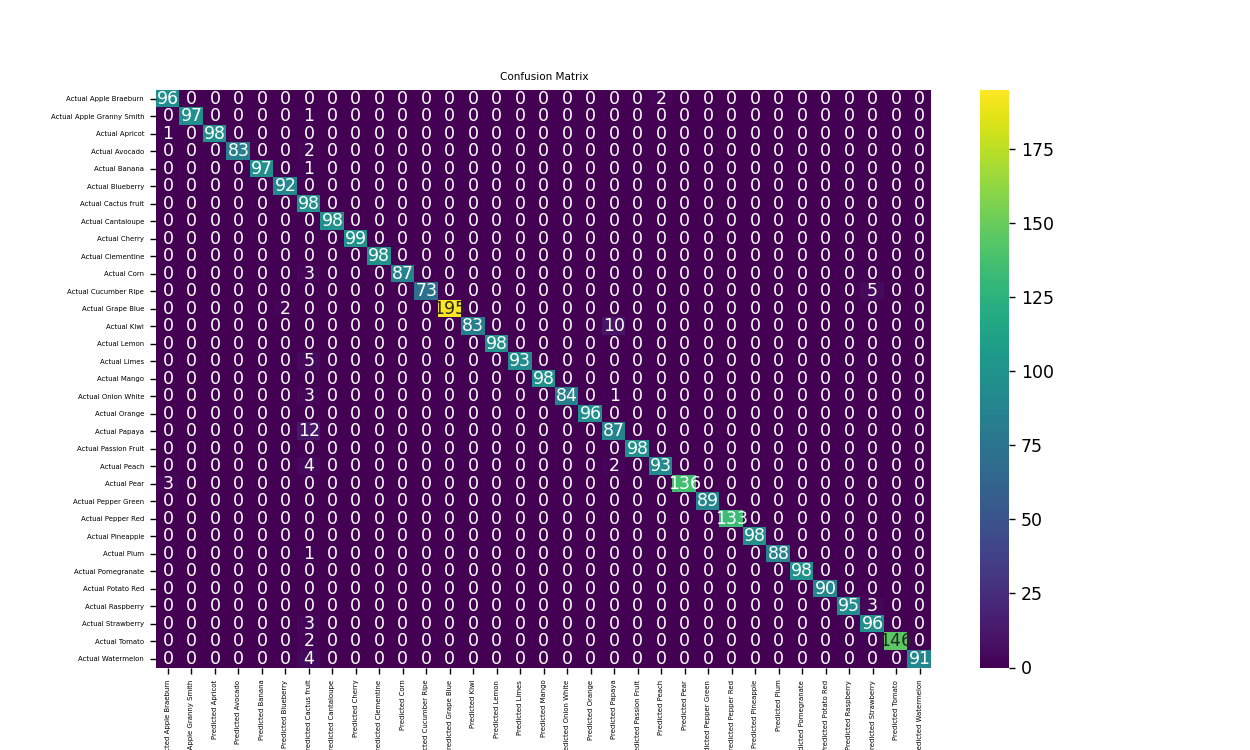

In [27]:
xtick_labels = ["Predicted {}".format(class_name) for class_name in shell_family.mapping]
ytick_labels = ["Actual {}".format(class_name) for class_name in shell_family.mapping]
print("Classification Report\n")
print(classification_report(y_test, y_predict))
print("")
print("Confusion Matrix\n")
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_predict), cmap="viridis", annot=True, fmt="d", xticklabels=xtick_labels, yticklabels=ytick_labels)
plt.title("Confusion Matrix", fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=4)
plt.show()

2D PCA

In [12]:
shell_family.classifiers[shell].noise_std

0.053275615

<IPython.core.display.Javascript object>


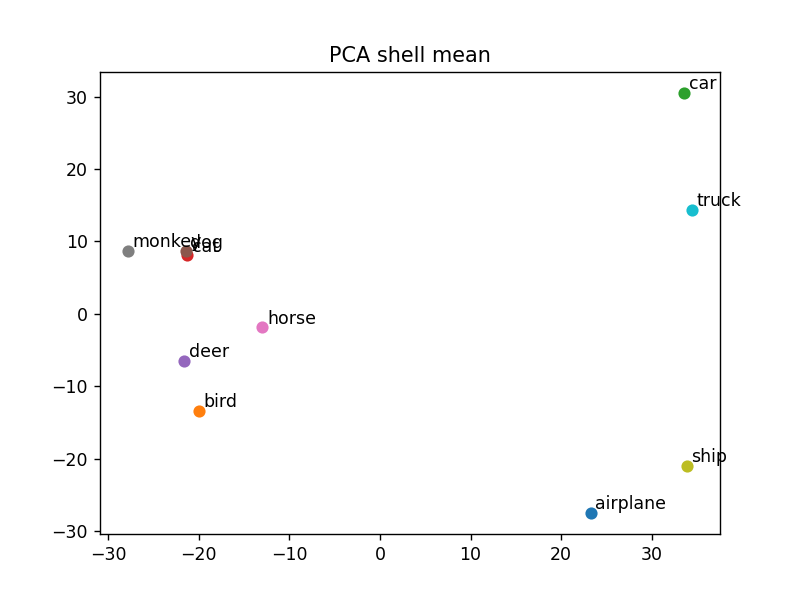

Text(0.5, 1.0, 'PCA shell mean')

In [11]:
mean_array = []
noise_array = []
for shell in shell_family.classifiers:
    mean_array.append(shell_family.classifiers[shell].shell_mean[0])
scaler = StandardScaler()
scaled_mean = scaler.fit_transform(mean_array)
pca = PCA(n_components=2, random_state=42)
transformed = pca.fit_transform(scaled_mean)
for i in range(len(transformed)):
    plt.scatter(transformed[i, 0], transformed[i, 1])
    plt.text(transformed[i, 0] + 0.5, transformed[i, 1] + 0.5, shell_family.mapping[i])
plt.title("PCA shell mean")

3D PCA

In [56]:
mean_array = []
for shell in shell_family.classifiers:
    mean_array.append(shell_family.classifiers[shell].shell_mean[0])
scaler = StandardScaler()
scaled_mean = scaler.fit_transform(mean_array)
pca = PCA(n_components=3, random_state=42)
transformed = pca.fit_transform(scaled_mean)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(transformed)):
    ax.scatter(transformed[i, 0], transformed[i, 1], transformed[i, 2])
    ax.text(transformed[i, 0] + 0.5, transformed[i, 1] + 0.5, transformed[i, 2], shell_family.mapping[i])
plt.title("PCA shell mean")


<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'PCA shell mean')